In [2]:
using HierarchicalDriving
import POMDPs:initial_state
using POMDPToolbox
using Interact
using MCTS
using AutoViz
import ParticleFilters: obs_weight
import Base: ==, +, *, -, <, >, copy, Random, hash

In [3]:
HORIZON = 15
TIME_STEP = 0.3
lb_x = (AVG_HWY_VELOCITY - 5.0) * TIME_STEP * HORIZON
ub_x = (AVG_HWY_VELOCITY + 5.0) * TIME_STEP * HORIZON
p = LowLevelMDP(0.99,TIME_STEP, HORIZON,
                            HierarchicalDriving.RoadSegment((-100.0, 500.0),[0.0, LANE_WIDTH, 2.0 * LANE_WIDTH, 3.0 * LANE_WIDTH, 4.0 * LANE_WIDTH]),
                            CarPhysicalState((0.0, 3.0 * LANE_WIDTH/2.0, AVG_HWY_VELOCITY)),
                            (CarPhysicalState((lb_x, 5.0 * LANE_WIDTH/2.0 - 0.5, AVG_HWY_VELOCITY - 5)),
                             CarPhysicalState((ub_x, 5.0 * LANE_WIDTH/2.0 + 0.5, AVG_HWY_VELOCITY + 5))),
                            50.0, -500.0, -1.0, -5.0, -5.0, -1.0, HierarchicalDriving.getFrameList());

In [16]:
function testing()
    n = 100
    sum = 0.0
    sum1 = 0.0
    numPositiveRnd = 0
    numPositiveMCTS = 0
    for i in 1:n
        #policy = RandomPolicy(p)
        policy = subintentional_lowlevel_policy(p)
        hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist = simulate(hr, p, policy)
        finState = state_hist(hist)[end]

        solver = DPWSolver(depth=p.HORIZON,
                               exploration_constant=10.0,
                               n_iterations=1_000,
                               k_action=10.0,
                               alpha_action=1/10,
                               k_state=5.0,
                               alpha_state=1/10,
                               #estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                              )
        policy1 = solve(solver, p)
        hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist1 = simulate(hr1, p, policy1)
        finState1 = state_hist(hist1)[end]
        

        println(i, ",", discounted_reward(hist), ",", discounted_reward(hist1))
        sum += discounted_reward(hist)
        sum1+= discounted_reward(hist1)
        if finState.terminal == 2 || HierarchicalDriving.checkTargetCoordinates(finState,p)
            numPositiveRnd += 1
        end
        if finState1.terminal == 2 || HierarchicalDriving.checkTargetCoordinates(finState1,p)
            numPositiveMCTS += 1
        end
    end
    println("Mean: ",sum/n,",", sum1/n)
    println("Success Rate: ", numPositiveRnd/n, ",", numPositiveMCTS/n)
end

testing (generic function with 1 method)

testing() in module Main at In[11]:2 overwritten at In[16]:2.


In [17]:
@time testing()

1,0.0,41.51433016439041
2,41.58177576142221,42.023356534159674
3,0.0,36.34854217177064
4,0.0,37.34292567696259
5,41.58177576142221,41.96908812855566
6,-0.470702276736646,42.188642689310704
7,0.0,40.74609341347663
8,0.0,-9.318328252879787
9,41.58177576142221,41.96797524253026
10,41.58177576142221,41.64227655767312
11,0.0,41.80407380446759
12,42.0210696654222,41.85725689677056
13,0.0,42.172192754087476
14,41.58177576142221,41.459519129541384
15,0.0,41.91206793161958
16,41.58177576142221,41.96963623890415
17,0.0,42.02225477699453
18,41.58177576142221,42.0430593551454
19,0.0,41.74429616899632
20,0.0,41.96851244548282
21,-1.3711187821329274,41.56692781276788
22,41.67082678674326,41.989892706706534
23,41.58177576142221,41.364137418140274
24,0.0,41.91314776381714
25,41.58177576142221,41.24840219389955
26,0.0,41.967432613285254
27,41.58177576142221,41.859460522389455
28,0.0,41.68997205924109
29,41.58177576142221,41.94082056918044
30,41.804733751047124,41.91316420768124
31,0.0,36.93513549205555

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(8, nactions=1),"i",8,"8",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

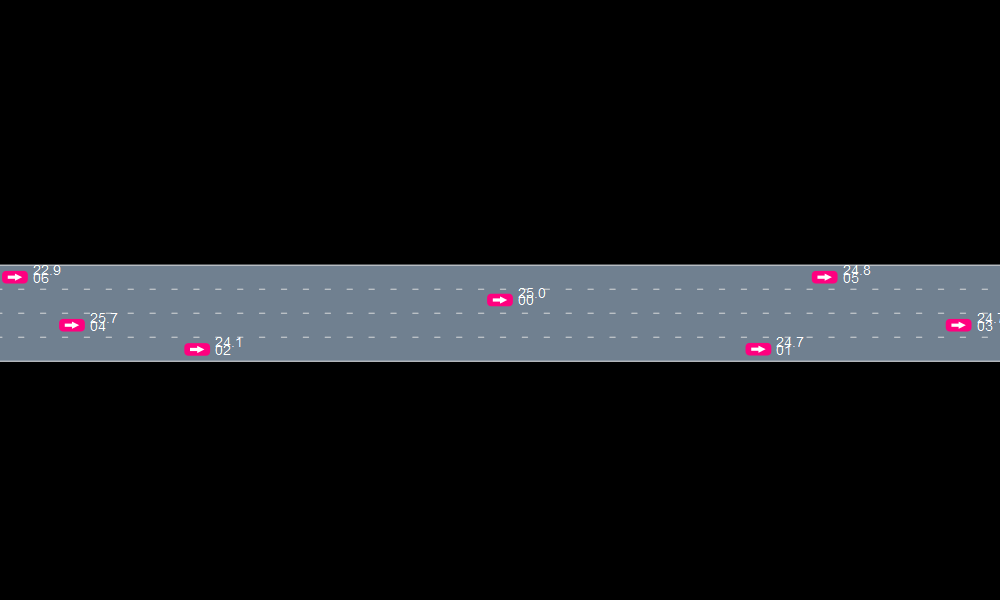

In [5]:
i = 5
#policy = RandomPolicy(p)
policy = subintentional_lowlevel_policy(p);
hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i));
hist = simulate(hr, p, policy);
@manipulate for i in 1:n_steps(hist)+1
    (p,state_hist(hist)[i],SceneOverlay[CarVelOverlay(), CarIDOverlay()])
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(8, nactions=1),"i",8,"8",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",16=>"16",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3"…)),Any[],Any[],true,"horizontal")

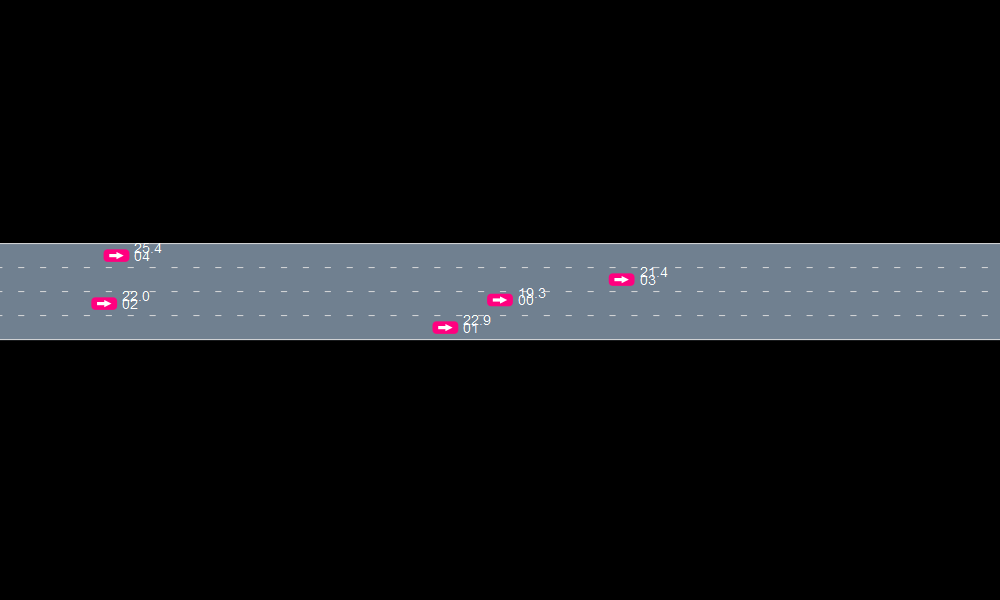

In [15]:
solver = DPWSolver(depth=p.HORIZON,
                           exploration_constant=10.0,
                           n_iterations=1_000,
                           k_action=10.0,
                           alpha_action=1/10,
                           k_state=5.0,
                           alpha_state=1/10,
                           estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                          )
policy1 = solve(solver, p)
hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
hist1 = simulate(hr1, p, policy1);
@manipulate for i in 1:n_steps(hist1)+1
    (p,state_hist(hist1)[i])
end

In [5]:
sh = state_hist(hist1)[end]
println(sh.ego)

HierarchicalDriving.CarPhysicalState((64.31508314322822,10.199999999999998,26.36390749962482))


In [6]:
discounted_reward(hist)

0.0

In [6]:
discounted_reward(hist1)

34.123558845652454